In [1]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import IPython
import librosa
import librosa.display
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [201]:
!ls /mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/bengalese_finch_sober/2019-10-10_18-44-37/WAV/

bl26lb16_190412_0721.20144.WAV
bl26lb16_190412_0722.20147.WAV
bl26lb16_190412_0723.20150.WAV
bl26lb16_190412_0723.20152.WAV
bl26lb16_190412_0724.20153.WAV
bl26lb16_190412_0725.20155.WAV
bl26lb16_190412_0731.20193.WAV
bl26lb16_190412_0739.20198.WAV
bl26lb16_190412_0742.20203.WAV
bl26lb16_190412_0743.20209.WAV
bl26lb16_190412_0745.20212.WAV
bl26lb16_190412_0746.20215.WAV
bl26lb16_190412_0750.20220.WAV
bl26lb16_190412_0753.20223.WAV
bl26lb16_190412_0755.20227.WAV
bl26lb16_190412_0758.20229.WAV
bl26lb16_190412_0759.20233.WAV
bl26lb16_190412_0802.20235.WAV
bl26lb16_190412_0803.20238.WAV
bl26lb16_190412_0807.20240.WAV
bl26lb16_190412_0808.20255.WAV
bl26lb16_190412_0811.20271.WAV
bl26lb16_190412_0814.20291.WAV
bl26lb16_190412_0817.20300.WAV
bl26lb16_190412_0823.20311.WAV
bl26lb16_190412_0823.20313.WAV
bl26lb16_190412_0830.20331.WAV
bl26lb16_190412_0832.20338.WAV
bl26lb16_190412_0834.20350.WAV
bl26lb16_190412_0836.20359.WAV
bl26lb16_190412_0837.20362.WAV
bl26lb16_190412_0837.20366.WAV
bl26lb16

In [202]:
wavloc = Path('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/bengalese_finch_sober/2019-10-10_18-44-37/WAV/bl26lb16_190412_0725.20155.WAV') 

In [237]:
y, sr = librosa.load(wavloc)
y = y[int(sr*8.66):int(sr*9.32)]

In [238]:
len(y), len(y)/sr, sr

(14553, 0.66, 22050)

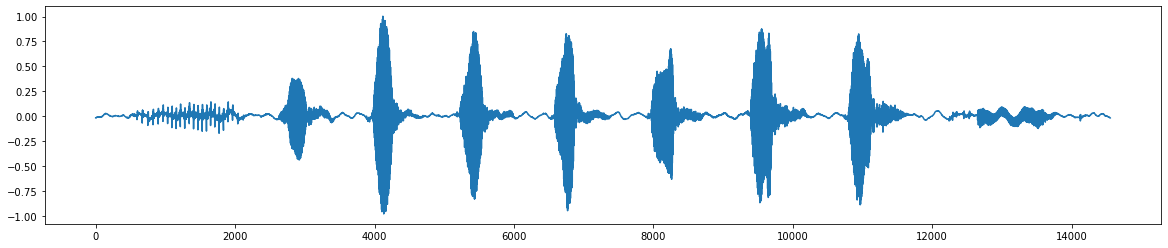

In [239]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(y)


In [320]:
n_fft = 256 
start_freq = 100
end_freq = 15000

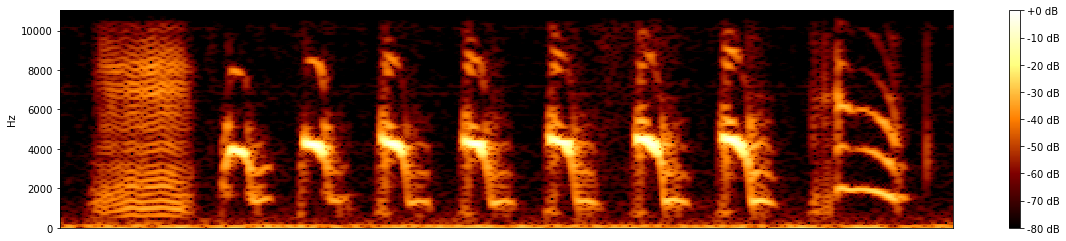

In [321]:
D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=32))**2
S_dB = librosa.power_to_db(D, ref=np.max)
spec = S_dB
freq_res = sr / 2 / spec.shape[0] 

fig, ax = plt.subplots(figsize=(20, 4))
img = librosa.display.specshow(
    spec[int(start_freq / freq_res) : int(end_freq / freq_res), :],
    cmap="afmhot",
    y_axis="linear",
    sr=sr,
    ax=ax,
)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

In [330]:
nit = 15

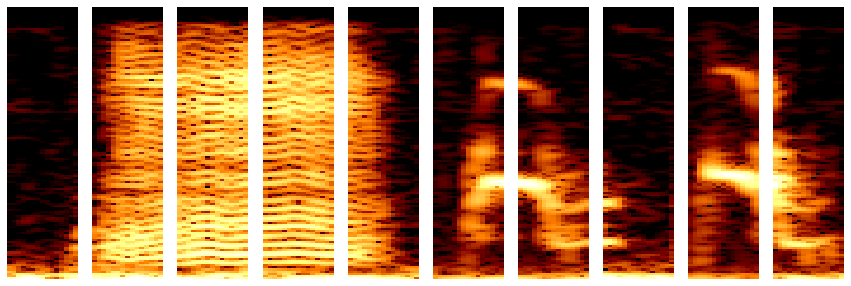

In [331]:
fig, axs = plt.subplots(ncols = 10, figsize=(15,5))
for axi, ax in enumerate(axs.flatten()):
    ax.matshow(
        spec[int(start_freq / freq_res) : int(end_freq / freq_res), axi*nit:(axi+1)*nit],
    cmap="afmhot",
        aspect='auto',
        origin='lower'
    )
    ax.axis('off')

### Superlet

In [246]:
from scipy.signal import fftconvolve
np.asnumpy = np.asarray

In [247]:
cp = np

In [248]:
# from https://gist.github.com/EtienneCmb/f76d8b4aba0088aba6a8c07e397a33c2
def bw_cf(t, bw, cf):
    """Computes the complex wavelet coefficients for the desired time point t,
    bandwidth bw and center frequency cf"""
    cnorm = 1 / (bw * np.sqrt(2 * np.pi))
    exp1 = cnorm * np.exp(-(t ** 2) / (2 * (bw ** 2)));
    res = np.exp(2j * np.pi * cf * t) * exp1
    return res


def gauss(t, sd):
    """Compute the gaussian coefficient for the desired time point t and
    standard deviation sd"""
    cnorm = 1 / (sd * np.sqrt(2 * np.pi))
    res = cnorm * np.exp(-(t ** 2) / (2 * (sd ** 2)))
    return res


def cxmorlet(fc, n_cycles, sfreq):
    """Computes the complex Morlet wavelet for the desired center frequency.
    
    Parameters
    ----------
    fc : center frequency
    n_cycles : number of cycles
    sfreq : sampling frequency
    """
    # we want to have the last peak at 2.5 SD
    sd = (n_cycles / 2) * (1 / fc) / 2.5
    wl = int(2 * np.floor(np.fix(6 * sd * sfreq) / 2) + 1)
    w = np.zeros((wl), dtype=np.complex128)
    gi = 0
    off = np.fix(wl / 2)
    for i in range(wl):
        t = (i - off) / sfreq
        w[i] = bw_cf(t, sd, fc)
        gi += gauss(t, sd)
    w /= gi
    return w


def aslt(data, sfreq, foi, n_cycles, order=None, mult=False):
    """Adaptive superresolution wavelet (superlet) transform.
    
    - data (array_like) : (n_epochs, n_times)
    - sfreq (float) : sampling frequency
    - foi (array_like) : central frequency of interest
    - n_cycles (integer) : number of initial wavelet cycles
    - order (array_like) : interval of super-resolution orders of shape (2,).
      For example, use order=[1, 30]
    - mult (bool) : specifies the use of multiplicative super-resolution (True)
      or additive (False)
    """
    # inputs checking
    assert isinstance(data, np.ndarray)
    data = np.atleast_2d(data).astype(np.float32)
    n_epochs, n_times = data.shape
    foi = np.asarray(foi)
    n_freqs = len(foi)

    # check order parameter and initialize the order used at each frequency. If
    # empty, go with an order of 1 for each frequency (single wavelet per set)
    if order is not None:
        order_ls = np.fix(np.linspace(order[0], order[1], n_freqs)).astype(int)
    else:
        order_ls = np.ones((n_freqs,), dtype=np.int)
        
    # the padding will be size of the lateral zero-pads, which serve to avoid
    # border effects during convolution
    padding = 0
    
    # the wavelet sets
    wavelets = dict()
    
    # initialize wavelet sets for either additive or multiplicative
    # superresolution
    for i_freq in tqdm(range(n_freqs), desc='n_freqs'):
        for i_ord in range(order_ls[i_freq]):
            # get the number of cycles
            if mult:  # multiplicative superresolution
                n_cyc = n_cycles * (i_ord + 1)
            else:     # additive superresolution
                n_cyc = n_cycles + i_ord
            
            # each new wavelet has n_cyc extra cycles
            _w = cxmorlet(foi[i_freq], n_cyc, sfreq)
            
            # the margin will be the half-size of the largest wavelet
            padding = max(padding, np.fix(len(_w) / 2))
            
            wavelets[(i_freq, i_ord)] = _w
    
    # the zero-padded buffer
    buffer = cp.zeros((n_epochs, int(n_times + 2 * padding)),
                      dtype=cp.float32)

    # convenience indexers for the zero-padded buffer
    bufbegin = int(padding)
    bufend = int(padding + n_times)
    
    # fill the central part of the buffer with input data
    buffer[:, bufbegin:bufend] = cp.asarray(data)
    
    # the output scalogram
    wtresult = cp.zeros((n_epochs, n_freqs, n_times), dtype=cp.float32)

    for i_freq in tqdm(range(n_freqs), desc='n_freqs'):
        # pooling buffer, starts with 1 because we're doing geometric mean
        temp = cp.ones((n_epochs, n_times), dtype=cp.float32)

        # compute the convolution of the buffer with each wavelet in the
        # current set
        for i_ord in range(order_ls[i_freq]):
            # get the single wavelets
            sw = cp.asarray(wavelets[(i_freq, i_ord)]).reshape(1, -1)
    
            # restricted convolution (input size == output size)
            _temp = fftconvolve(buffer, sw, mode='same', axes=1)

            # accumulate the magnitude (times 2 to get the full spectral
            # energy
            temp *= (2 * cp.abs(_temp[:, bufbegin:bufend]))

        # compute the power of the geometric mean
        root = 1. / float(order_ls[i_freq])
        temp = (temp ** root) ** 2

        # accumulate the current FOI to the result spectrum
        wtresult[:, i_freq, :] += temp
    
    return cp.asnumpy(wtresult)

In [249]:
#- data (array_like) : (n_epochs, n_times)
#- sfreq (float) : sampling frequency
#- foi (array_like) : central frequency of interest
#- n_cycles (integer) : number of initial wavelet cycles
#- order (array_like) : interval of super-resolution orders of shape (2,).
#  For example, use order=[1, 30]
#- mult (bool) : specifies the use of multiplicative super-resolution (True)
#  or additive (False)

In [250]:
np.log(500)/np.log(10)

2.6989700043360183

In [251]:
foi = np.linspace(10, sr/2, 256)

In [252]:
n_cycles = 100
order = [1, 30]
foi.shape

(256,)

In [253]:
superlet = aslt(y, sr, foi= foi, n_cycles=n_cycles, order=None, mult=False)

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n_freqs:   0%|          | 0/256 [00:00<?, ?it/s]

n_freqs:   0%|          | 0/256 [00:00<?, ?it/s]

In [254]:
superlet.shape

(1, 256, 14553)

In [255]:
log_superlet = np.log10(superlet[0]**2)

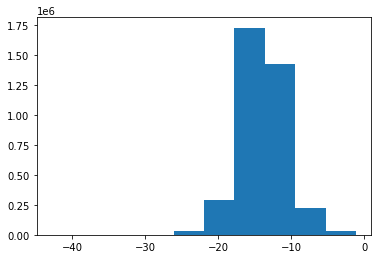

In [256]:
plt.hist(log_superlet.flatten());

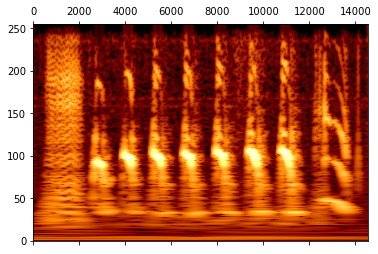

In [259]:
fig, ax = plt.subplots()
ax.matshow(log_superlet, aspect="auto", interpolation=None, origin="lower", cmap=plt.cm.afmhot, vmin = -20)

In [260]:
import libtfr

In [311]:
"""
s - input signal (real)
N - number of frequency points
step - step size (in time points)
Np - window size (should be <= N)
K - number of tapers to use (default 6)
tm - time support of tapers (default 6.0)
flock - frequency locking parameter; power is not reassigned
        more than this value (normalized frequency; default 0.01)
tlock - time locking parameter (in frames; default 5)
fgrid - output frequency bins: monotonically increasing
        (default linear scale with N points; Nyquist is 1.0)

returns an N/2+1 by L power spectrogram, or if fgrid is specified,
fgrid.size by L
"""
nfft = 500
Np = nfft
shift = nfft/16
K = 6
tm = 6.0
flock = 0.01
tlock = 5*2

In [312]:
from tqdm.autonotebook import tqdm

In [313]:
np.max(S) == np.inf

False

In [314]:
for i in tqdm(range(1000)):
    S = np.abs(libtfr.tfr_spec(s=y, N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
    
    if np.max(S) != np.inf:
        break
    break
print(np.shape(S), np.max(S), np.min(S))

  0%|          | 0/1000 [00:00<?, ?it/s]

(251, 454) 452.53717663922595 0.0


In [315]:
S = librosa.power_to_db(S, ref=np.max)
print(np.shape(S), np.max(S), np.min(S))

(251, 454) 0.0 -80.0


In [316]:
S_tfr = S

(-0.5, 453.5, -0.5, 250.5)

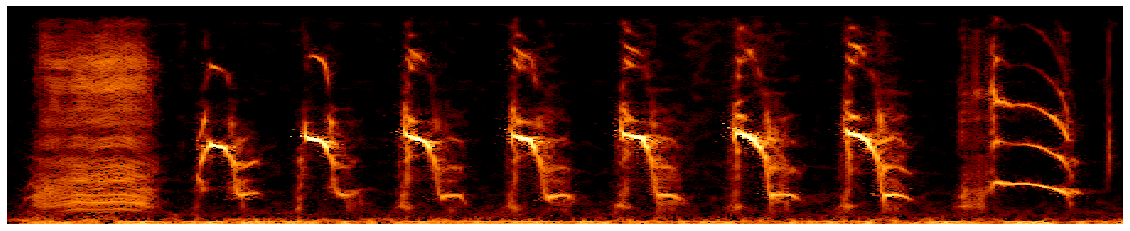

In [317]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.matshow(S, aspect='auto', origin='lower', cmap='afmhot')
ax.axis('off')